# In this notebook we will be doing some sentiment analysis in python using two different techniques:
1. VADER (Valence Aware Dictionary and sEntiment Reasoner) - Bag of words approach
2. Roberta Pretrained Model 


# Read in Data and NLTK Basics

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [41]:
# Read in data
sheet_id = '1C9wh8HLncoi4_1OCB-UFmyoMW0h4QYcWswGwC1Qxeik'
df = pd.read_csv(f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv")

print(df.shape)
df = df.head(100)
print(df.shape)

(113, 12)
(100, 12)


In [42]:
df.head()

,Name,category,product_id,user_id,date,time,Email,rating,Feedback,Sentiment,Id,label
0,Emma Johnson,Electronics,938562,emma96,2023-04-27,13:23,emma.johnson@example.com,4,jaideepak.s.h.2020.cse@ritchennai.edu.inThe pr...,NaN,1,0
1,John Smith,Home,284739,johnsmith,2023-04-30,9:47,john.smith@example.com,3,@user when a father is dysfunctional and is so...,NaN,2,0
2,Sarah Lee,Clothing,672915,sarah_lee,2023-04-26,18:12,sarah.lee@example.com,5,@love the design and quality! #good,NaN,3,0
3,Alex Chen,Beauty,583029,alexc123,2023-05-01,21:01,alex.chen@example.com,4,"Works well, but the smell is too strong. #best",NaN,4,0
4,Rachel Kim,Sports,109385,rachelk,2023-04-28,15:37,rachel.kim@example.com,5,Great product! I use it every day! #useful,NaN,5,0


## Quick EDA

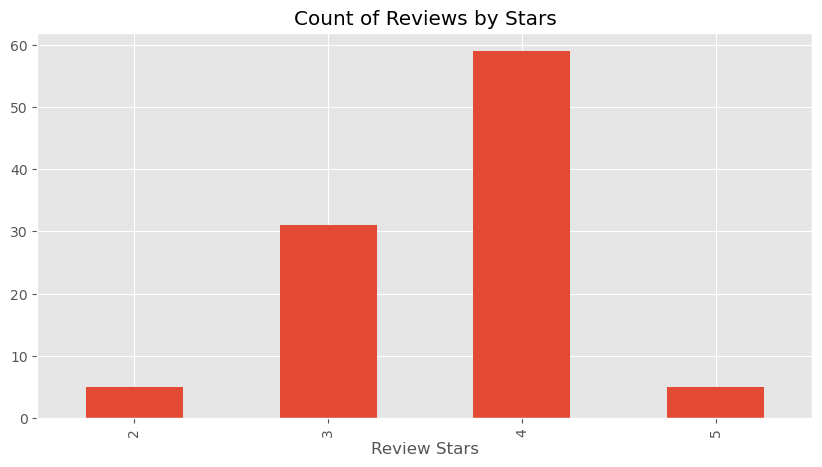

In [43]:
ax = df['rating'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

## Basic NLTK

In [44]:
example = df['Feedback'][50]
print(example)

The product was easy to set up and worked well


In [45]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['The', 'product', 'was', 'easy', 'to', 'set', 'up', 'and', 'worked', 'well']

In [46]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('The', 'DT'),
 ('product', 'NN'),
 ('was', 'VBD'),
 ('easy', 'JJ'),
 ('to', 'TO'),
 ('set', 'VB'),
 ('up', 'RP'),
 ('and', 'CC'),
 ('worked', 'VBD'),
 ('well', 'RB')]

In [47]:
nltk.data.path
nltk.download('maxent_ne_chunker')
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  The/DT
  product/NN
  was/VBD
  easy/JJ
  to/TO
  set/VB
  up/RP
  and/CC
  worked/VBD
  well/RB)


[nltk_data] Error loading maxent_ne_chunker: <urlopen error [WinError
[nltk_data]     10060] A connection attempt failed because the
[nltk_data]     connected party did not properly respond after a
[nltk_data]     period of time, or established connection failed
[nltk_data]     because connected host has failed to respond>


# VADER Seniment Scoring

We will use NLTK's `SentimentIntensityAnalyzer` to get the neg/neu/pos scores of the text.

- This uses a "bag of words" approach:
    1. Stop words are removed
    2. each word is scored and combined to a total score.

In [48]:
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

[nltk_data] Error loading vader_lexicon: <urlopen error [WinError
[nltk_data]     10060] A connection attempt failed because the
[nltk_data]     connected party did not properly respond after a
[nltk_data]     period of time, or established connection failed
[nltk_data]     because connected host has failed to respond>


In [49]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [50]:
sia.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [51]:
sia.polarity_scores(example)

{'neg': 0.0, 'neu': 0.615, 'pos': 0.385, 'compound': 0.6124}

In [52]:
res = {}
for i, row in df.iterrows():
    text = row['Feedback']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)


In [53]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

In [54]:
# Now we have sentiment score and metadata
vaders.head()

,Id,neg,neu,pos,compound,Name,category,product_id,user_id,date,time,Email,rating,Feedback,Sentiment,label
0,1,0.000,0.406,0.594,0.6588,Emma Johnson,Electronics,938562,emma96,2023-04-27,13:23,emma.johnson@example.com,4,jaideepak.s.h.2020.cse@ritchennai.edu.inThe pr...,NaN,0
1,2,0.402,0.598,0.000,-0.8296,John Smith,Home,284739,johnsmith,2023-04-30,9:47,john.smith@example.com,3,@user when a father is dysfunctional and is so...,NaN,0
2,3,0.000,1.000,0.000,0.0000,Sarah Lee,Clothing,672915,sarah_lee,2023-04-26,18:12,sarah.lee@example.com,5,@love the design and quality! #good,NaN,0
3,4,0.000,0.538,0.462,0.7184,Alex Chen,Beauty,583029,alexc123,2023-05-01,21:01,alex.chen@example.com,4,"Works well, but the smell is too strong. #best",NaN,0
4,5,0.000,0.562,0.438,0.6892,Rachel Kim,Sports,109385,rachelk,2023-04-28,15:37,rachel.kim@example.com,5,Great product! I use it every day! #useful,NaN,0


## Plot VADER results

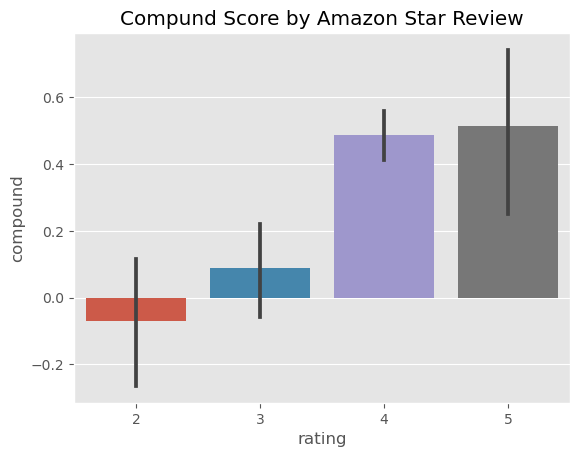

In [55]:
ax = sns.barplot(data=vaders, x='rating', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

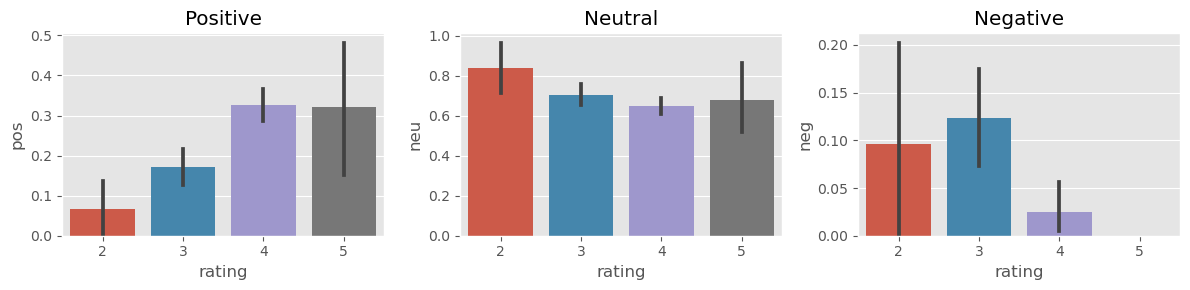

In [56]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='rating', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='rating', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='rating', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

# Roberta Pretrained Model

- Use a model trained of a large corpus of data.
- Transformer model accounts for the words but also the context related to other words.

In [57]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [58]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [59]:
# VADER results on example
print(example)
sia.polarity_scores(example)

The product was easy to set up and worked well


{'neg': 0.0, 'neu': 0.615, 'pos': 0.385, 'compound': 0.6124}

In [60]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.002720142, 'roberta_neu': 0.03214942, 'roberta_pos': 0.96513045}


In [61]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [62]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Feedback']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')       

  0%|          | 0/100 [00:00<?, ?it/s]

In [63]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

## Compare Scores between models

In [64]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'Name', 'category',
       'product_id', 'user_id', 'date', 'time', 'Email', 'rating', 'Feedback',
       'Sentiment', 'label'],
      dtype='object')

#  Combine and compare

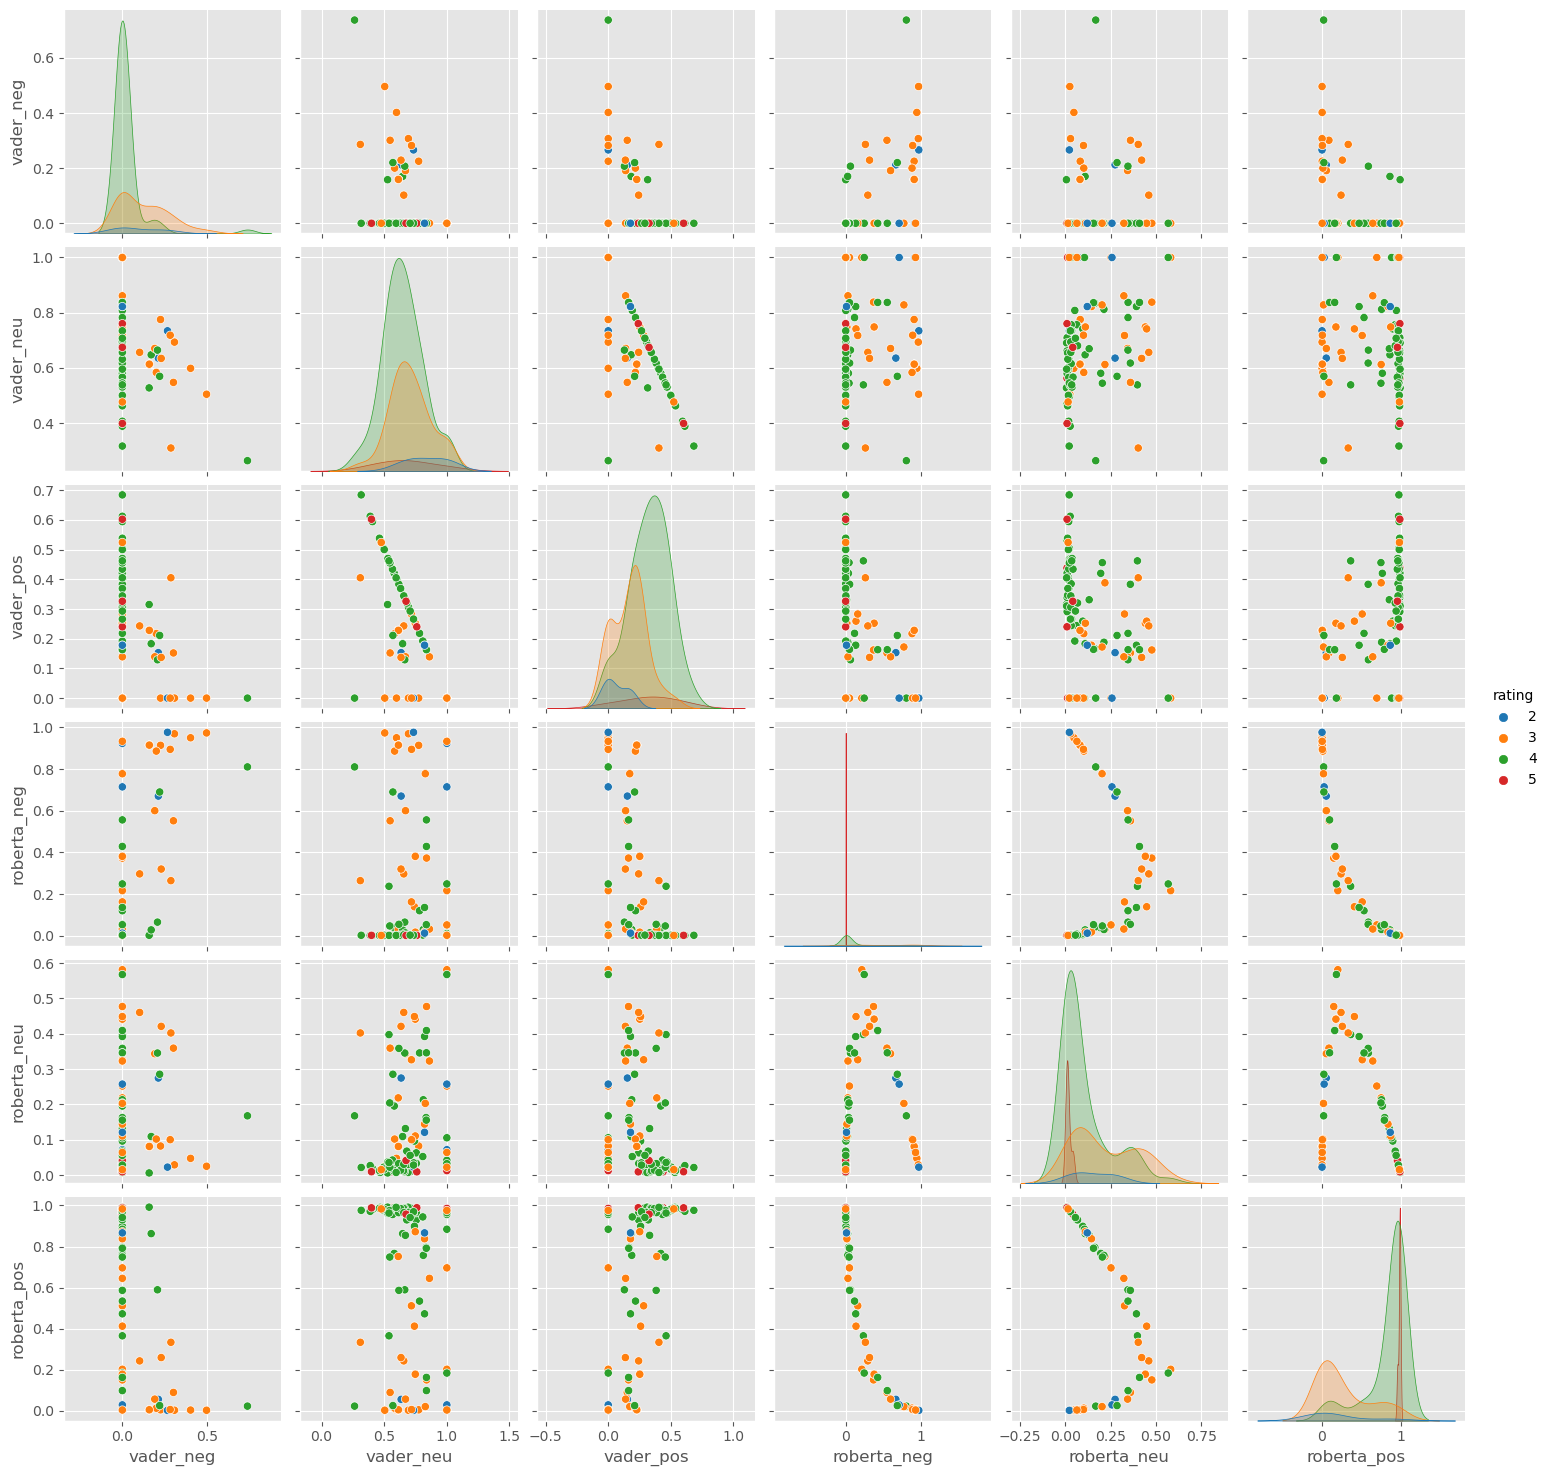

In [65]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='rating',
            palette='tab10')
plt.show()

#  Review Examples:

- Positive 4-Star and Negative 5-Star Reviews

Lets look at some examples where the model scoring and review score differ the most.

In [80]:
results_df.query('rating == 4') \
    .sort_values('roberta_pos', ascending=False)['Feedback'].values[0]

'I absolutely love this product! My skin has never looked better'

In [81]:
results_df.query('rating == 4') \
    .sort_values('vader_pos', ascending=False)['Feedback'].values[0]

'The clothing was great quality and fit perfectly'

In [71]:
# nevative sentiment 5-Star view

In [72]:
results_df.query('rating == 5') \
    .sort_values('roberta_neg', ascending=False)['Feedback'].values[0]

'@love the design and quality! #good'

In [73]:
results_df.query('rating == 5') \
    .sort_values('vader_neg', ascending=False)['Feedback'].values[0]

'@love the design and quality! #good'

# The Transformers Pipeline
- Quick & easy way to run sentiment predictions

In [82]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Xformers is not installed correctly. If you want to use memorry_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [83]:
sent_pipeline('I love sentiment analysis!')

[{'label': 'POSITIVE', 'score': 0.9997853636741638}]

In [84]:
sent_pipeline('Make sure to like and subscribe!')

[{'label': 'POSITIVE', 'score': 0.9991742968559265}]

In [85]:
sent_pipeline('booo')

[{'label': 'NEGATIVE', 'score': 0.9936267137527466}]